In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import os
from matplotlib import pyplot as plt

datapath = '/home/lautaro/Workspace/ib/code/codedoc/realdata/redes/FAO'

## 09/10: Primer paso, dataset (nombres + coordenadas)

In [94]:
# Paso de latitud/longitud a coordenadas x, y en la proy. Mercator (en km)
def merc_from_arrays(lats, lons):
    # Voy a usar como unidad de longitud 1 km (10^3 m)
    r_major = 6378.137000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.vstack((x, y)).T

In [142]:
# Voy a armar y guardar el dataset de nodos con los datos de latitud/longitud
coords = pd.read_csv(os.path.join(datapath, 'coordinate-countries-fixed.csv'))
coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
coords['x'] = coordinates[:, 0]
coords['y'] = coordinates[:, 1]
# El codigo de Namibia se rompe
coords.loc[coords['Country'] == 'Namibia', 'Code'] = 'NAM'

nodes = pd.read_csv(os.path.join(datapath, 'nodes-fixed.csv'))
nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
# Drop row from nodes where 'Name' is 'unspecified'
nodes = nodes[nodes['name'] != 'Unspecified']
# Reemplazo '_' con ' ' para que matcheen mas paises
nodes['name'] = nodes['name'].str.replace('_', ' ')

# Merge DataFrames A and B based on matching country names
merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

# Filter and sort the merged DataFrame
merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
merged_nodes.reset_index(drop=True, inplace=True)

merged_nodes.to_csv(os.path.join(datapath, 'nodes-merged.csv'), index=False)

In [170]:
def get_data(layer=1, info=False):

    prods = eval(open(os.path.join(datapath, "gprops-fixed.csv")).read())

    merged_nodes = pd.read_csv(os.path.join(datapath, 'nodes-merged.csv'))

    all_edges = pd.read_csv(os.path.join(datapath, 'edges.csv'))
    all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

    unique_count = all_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    # Filtro solo un layer (layer + 1 porque hice que gprops empiece en 0)
    one_layer_edges = all_edges[all_edges['layer'] == layer + 1]    # CUIDADO ACA: Entender porque es layer+1 (mirar gprops-fixed.csv)
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    unique_count = one_layer_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    if info:
        print(f"Layer {layer}: {prods[layer]}\nNumber of countries:", unique_count)

    filtered_nodes = merged_nodes[merged_nodes['index'].isin(one_layer_edges['source']) | merged_nodes['index'].isin(one_layer_edges['target'])]

    G = nx.from_pandas_edgelist(one_layer_edges, source= 'source', target = 'target')

    pos = {node : [filtered_nodes.loc[filtered_nodes['index'] == node, 'x'].values[0], filtered_nodes.loc[filtered_nodes['index'] == node, 'y'].values[0]] for node in filtered_nodes['index']}
    
    codes = {node : filtered_nodes.loc[filtered_nodes['index'] == node, 'Code'].values[0] for node in filtered_nodes['index']}

    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, codes, 'code')

    return G, filtered_nodes

def draw(G, map=False, show_labels=True):
    pos = nx.get_node_attributes(G, 'pos')
    codes = nx.get_node_attributes(G, 'code')
    pos_text = {i: [v[0], v[1] - 500] for i, v in pos.items()}
    # fig, ax = plt.subplots(figsize=(15,8))
    fig, ax = plt.subplots(dpi=500)
    if map:
        imgpath = os.path.join(os.getcwd(), 'mapa5a.png')
        image = plt.imread(imgpath)
        ax.imshow(image, extent=[-20000, 23000, -10000, 14500])
    if show_labels:
        nx.draw_networkx_labels(G, pos_text, codes, font_size=4)
    nx.draw(G, pos=pos, node_size=10, width=.05, ax=ax)

### Grafico la red con grafo de fondo

Layer 9: Forage_products
Number of countries: 109


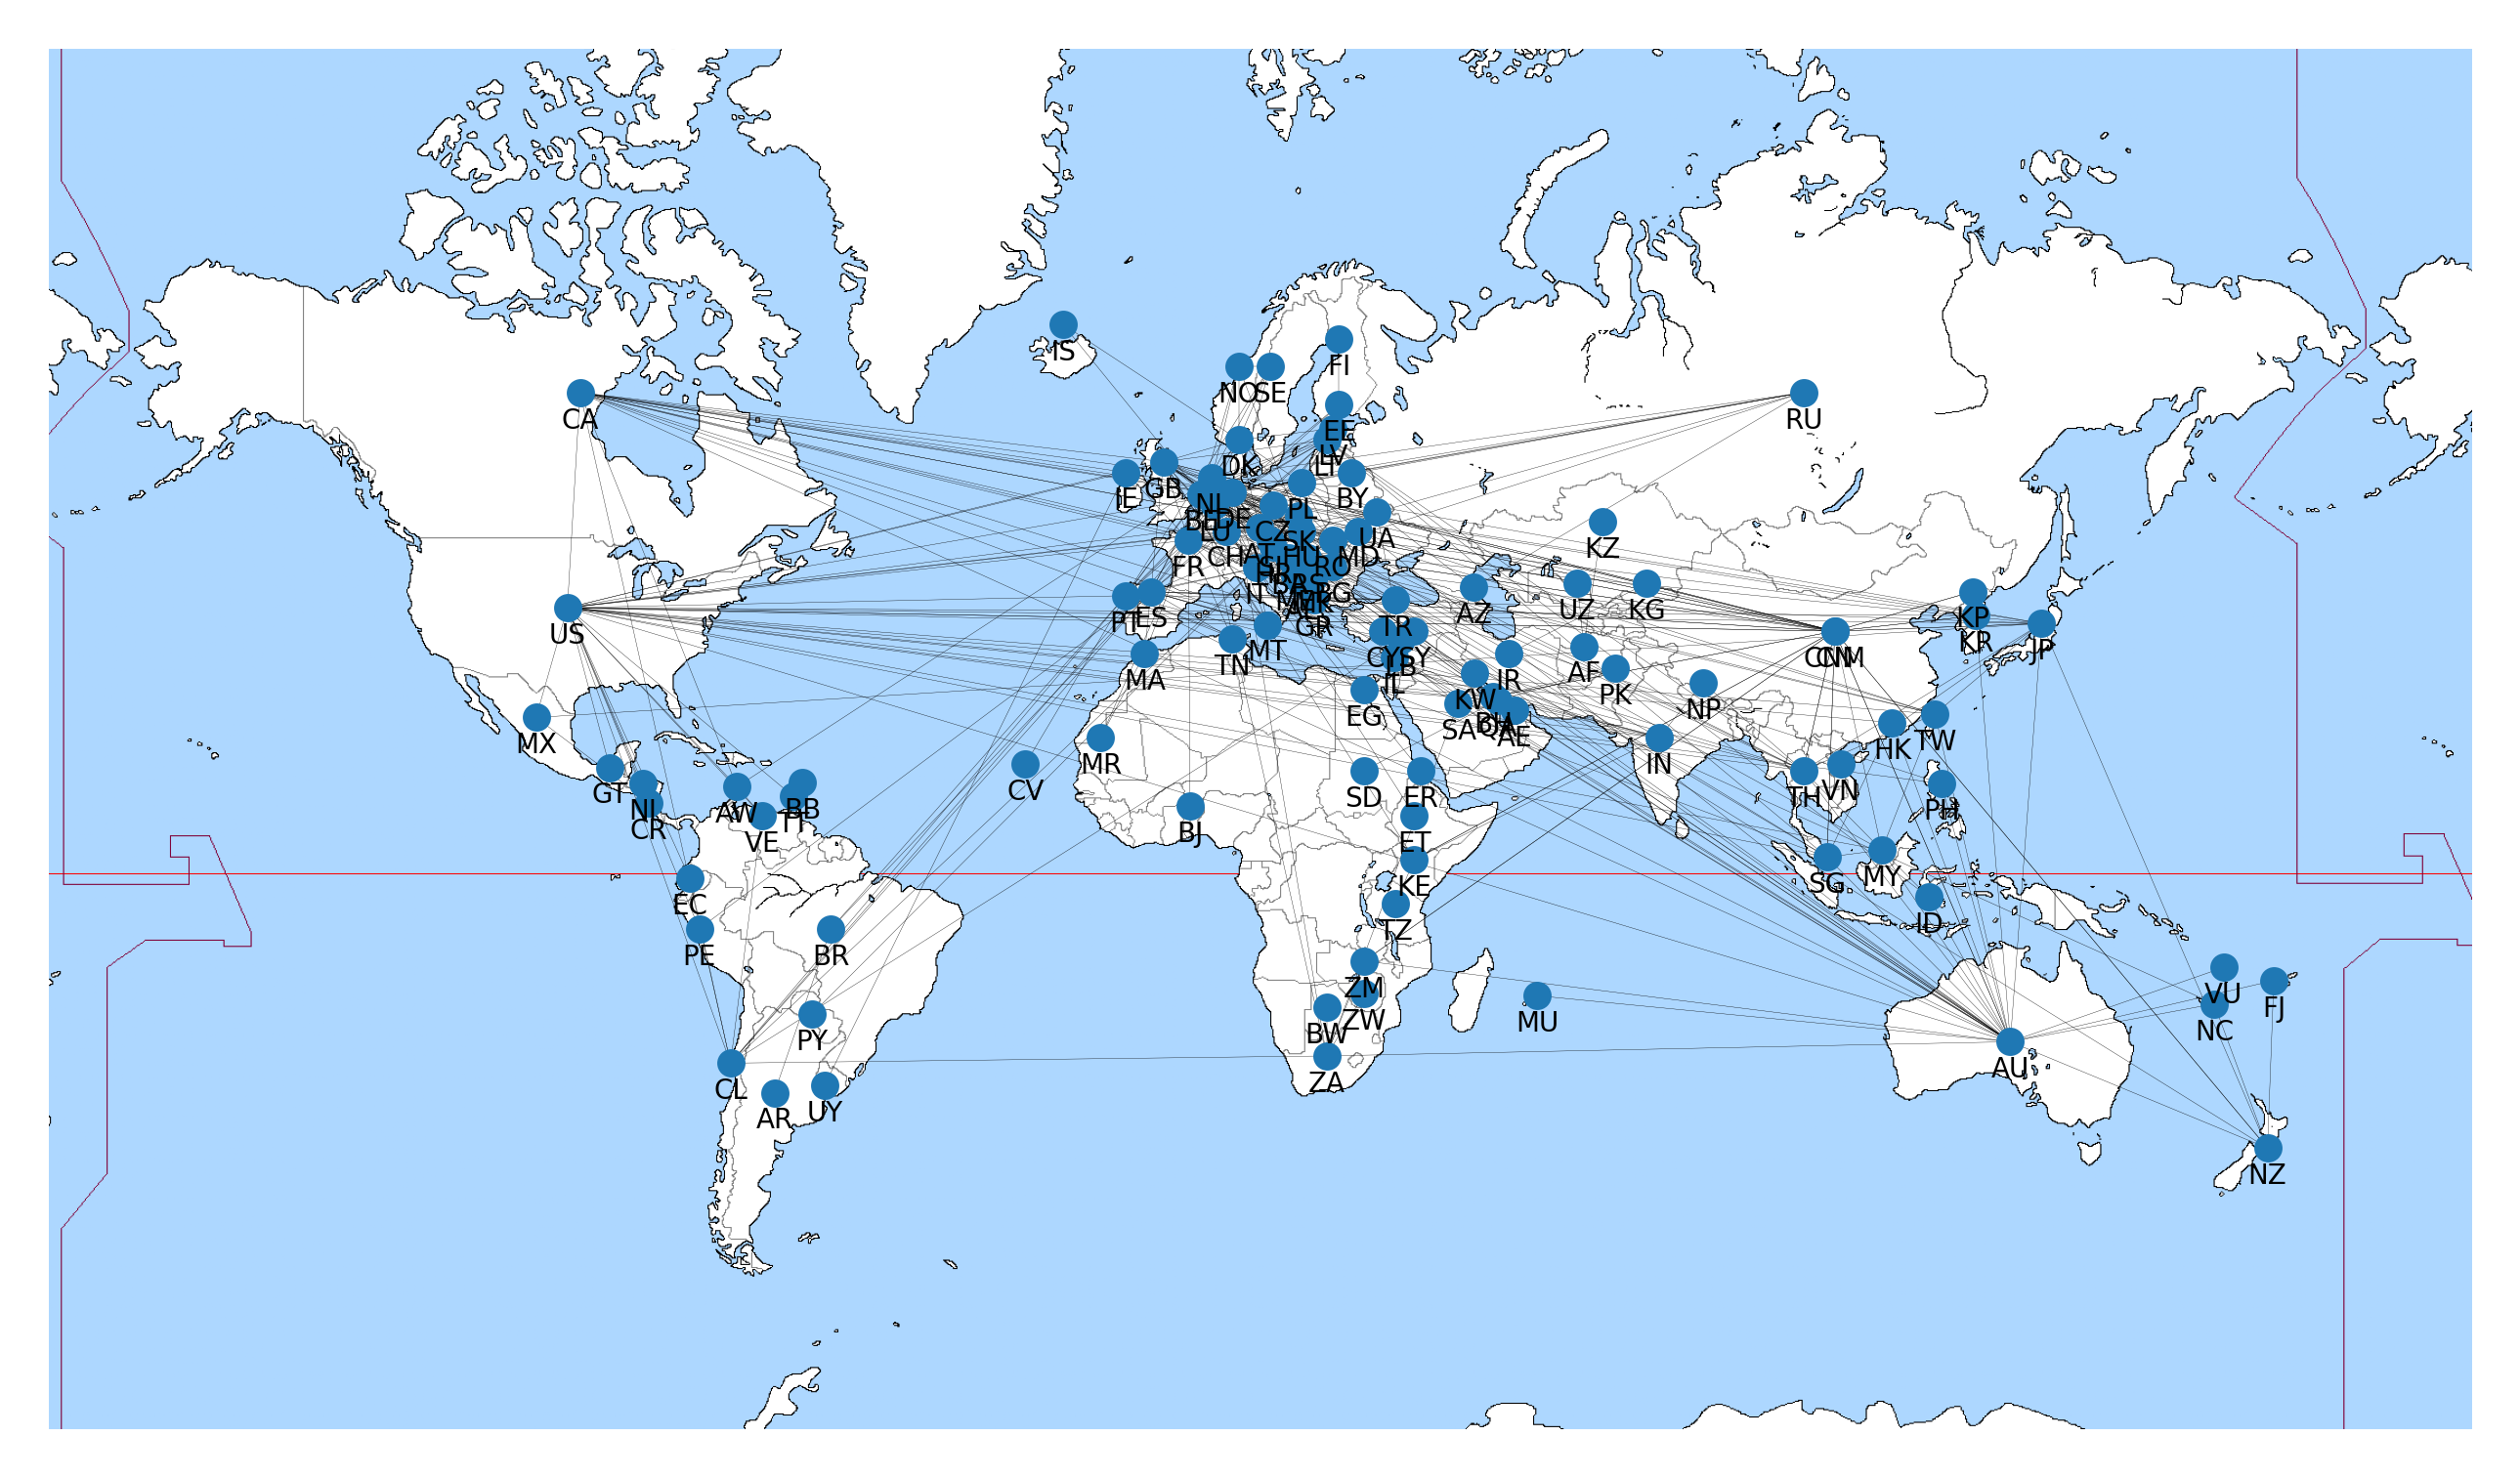

In [171]:
G, filtered_nodes = get_data(9, info=True)
draw(G, map=True)

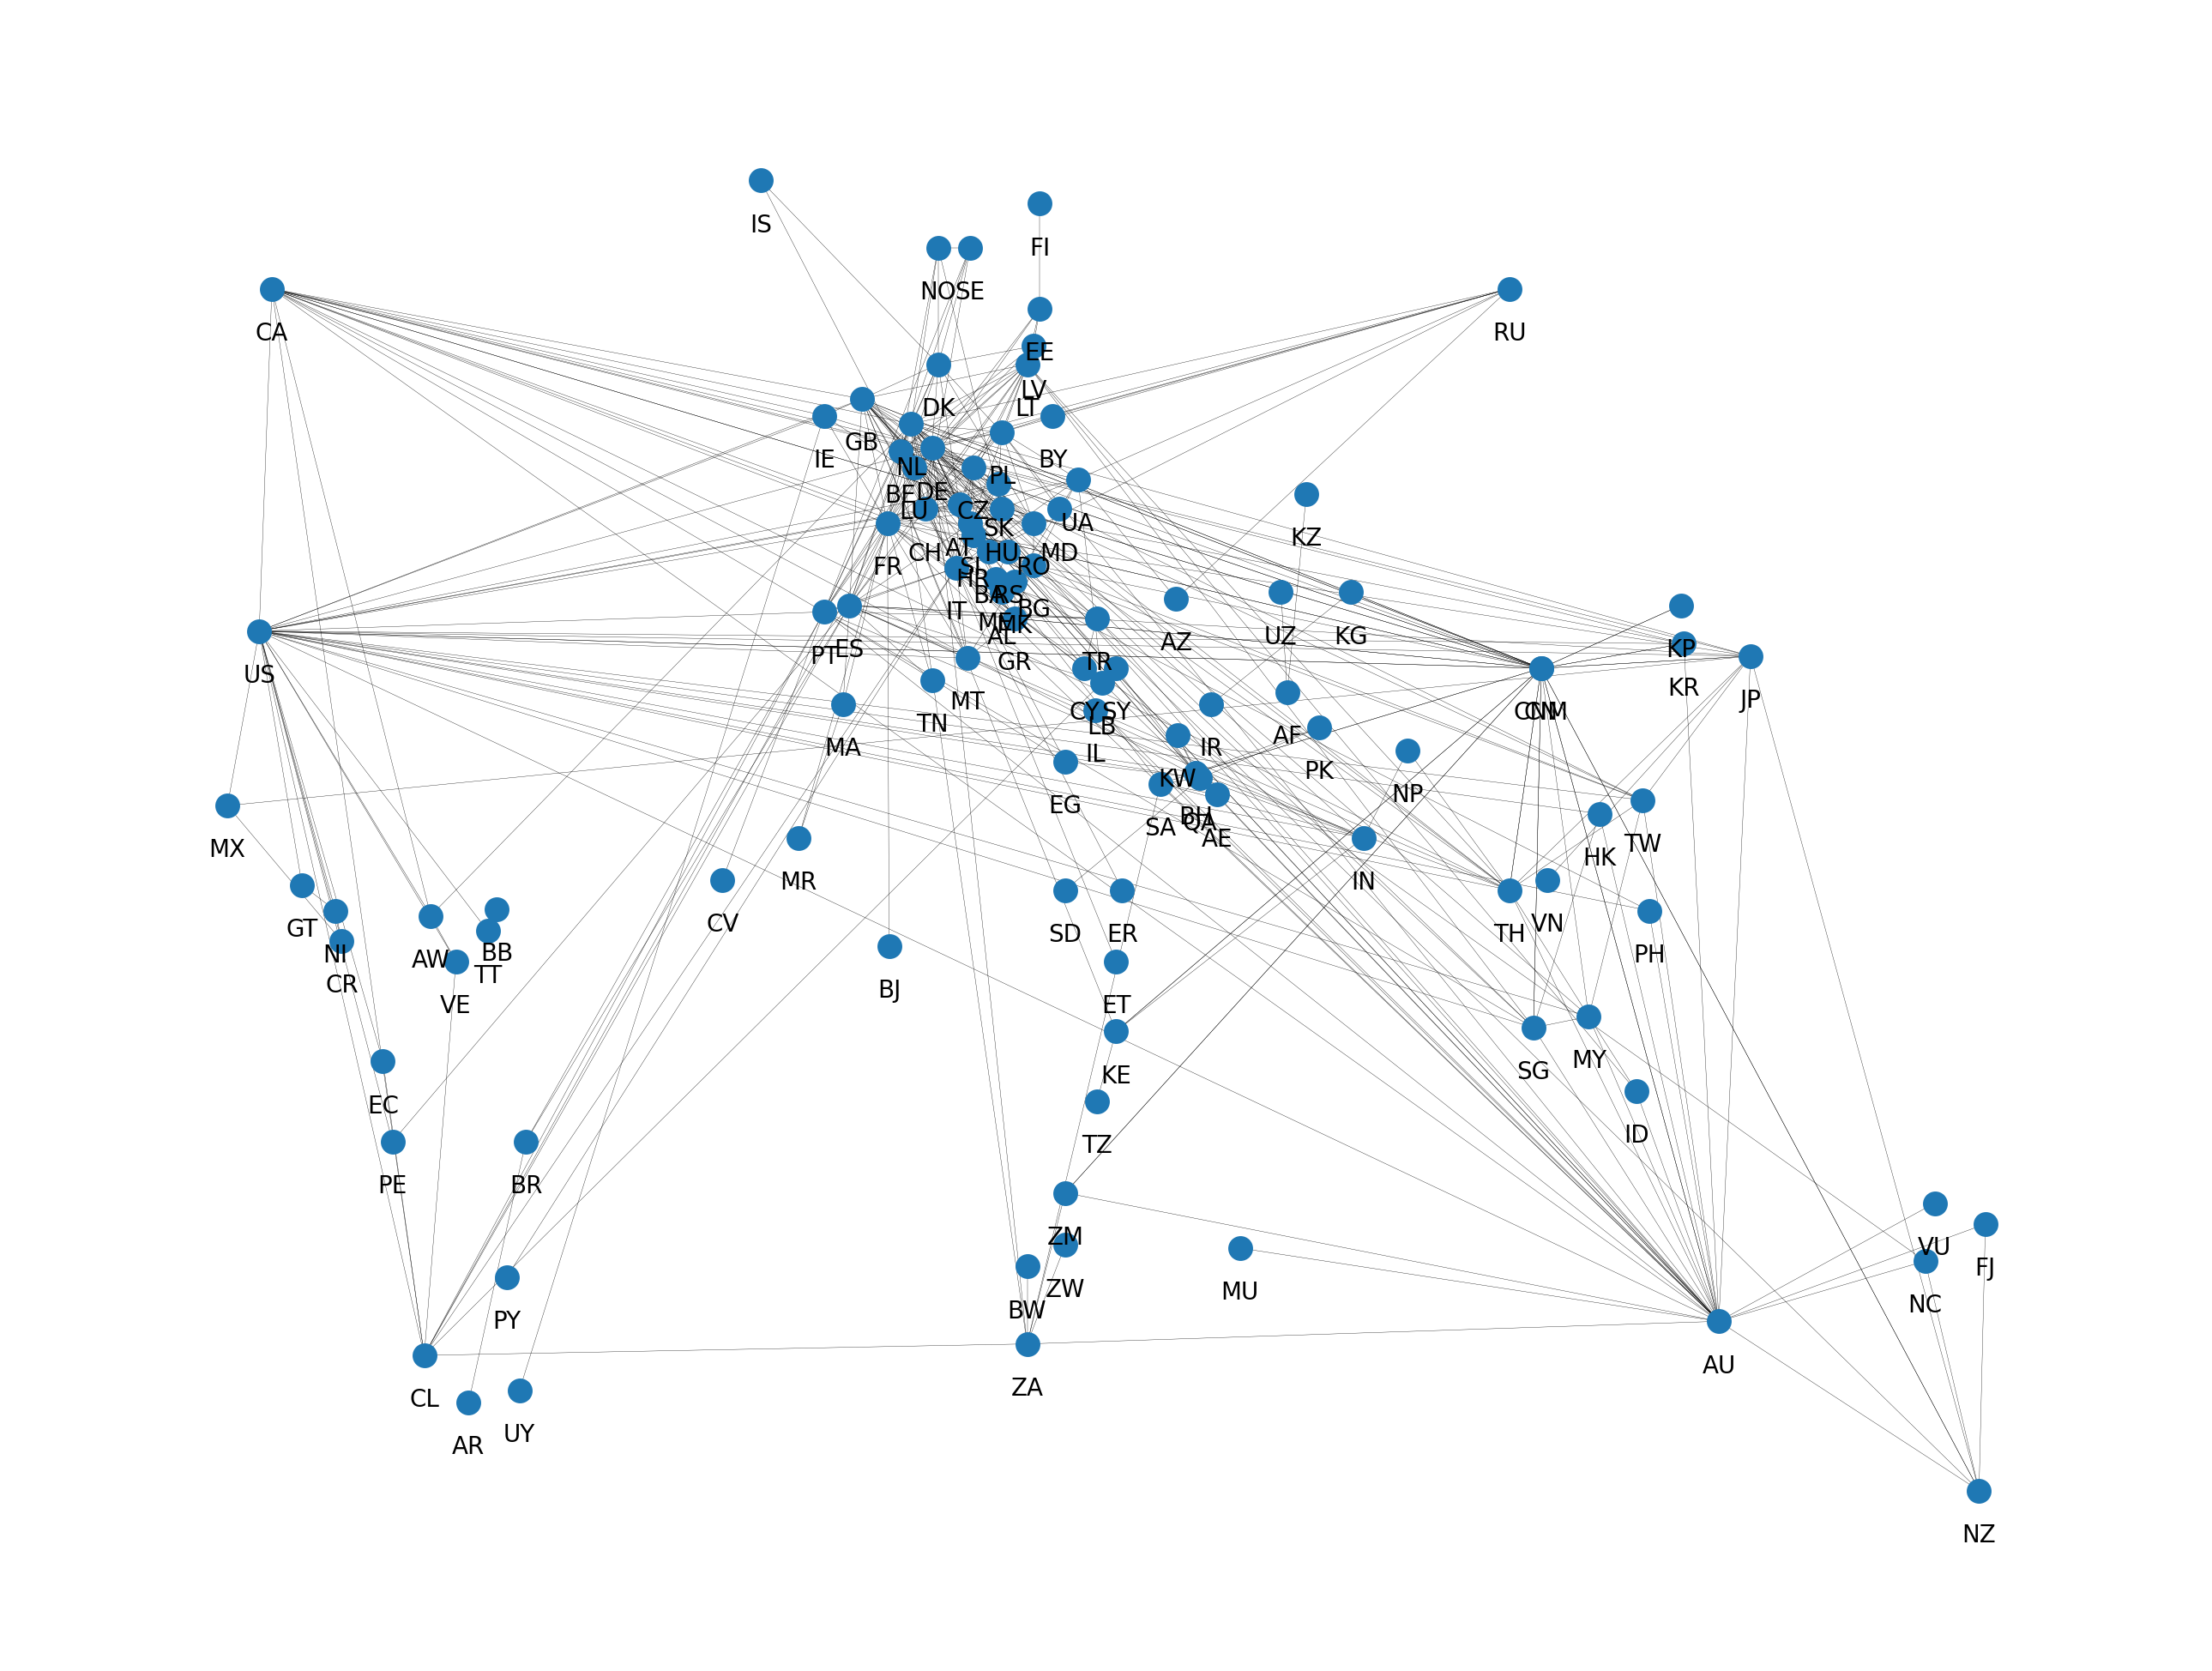

In [167]:
draw(G)

### Usando datos de imp/exp

In [193]:
imports = pd.read_csv(os.path.join(datapath, 'imports_by_country.csv'), index_col=0)
exports = pd.read_csv(os.path.join(datapath, 'exports_by_country.csv'), index_col=0)

# Left join A and B on 'name' column
merged_df = exports.merge(imports, on='name', how='left')

# Fill missing 'imports' with 0
merged_df['imports (m usd)'].fillna(0, inplace=True)

# Calculate the sum of 'exports' and 'imports' for each row
merged_df['i + e (m usd)'] = merged_df['exports (m usd)'] + merged_df['imports (m usd)']

# Select the columns you want to keep in the resulting dataframe (A)
total_trade = merged_df[['name', 'i + e (m usd)']]
total_trade.to_csv(os.path.join(datapath, 'total_trade_by_country.csv'), index=False)